### STEP **THREE** OF DATA PROCESSING PIPELINE

#### This script imports all Conditional CRF's for each subject and the results are visualized 
#### This script performs the 2 exclusion criteria tests: Average Response was withing X STD and Post - Pre CRF ACtivity did not exceed the mean response for Y% of the Time
#### 1: Each response was analyzed per contrast, per harmonic

#### 2 Types of plots (4 in total): 
####  Average CRF before and after excluding  participants fbased on Exclusion Criteria

In [1]:
# load packages
import numpy as np 
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [2]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
NumConds = 4

In [3]:
def Concat_Dict_Data(NumSubs,SubNames,d1,d2,iters,s2):
    """
    Combine Single and Double Session Participants data
    Returns: Dict and subject name array

    NumSubs: Number of Participants who completed 2x Sessions 
    d1: Dict Data of Participants who completed 2x Sessions for this condition
    d2: Dict Data of Participants who completed 1 Session for this condition
    iters: **Total Subjects** 
    s2: List of subnames for single sessions  
    """
    s1 = SubNames
    add_onInd = int(iters - NumSubs) # single subjs
    CondSubList = np.hstack((s1,s2)) # Combine subject lists 
    d_sess = np.arange(NumSubs) 
    s_sess = np.arange(add_onInd)
    new_list = np.concatenate((d_sess,s_sess+len(d1)))

    condDict = {}
    for Sub in range(int(iters)): # all data for condition
        ind = int(new_list[Sub]) # restart dict inds
        if Sub < len(d1):
            condDict[Sub]  = d1[ind]
        else: # start saving singles session data 
            condDict[Sub]  = d2[ind - len(d1)]
    return condDict , CondSubList 
############################################################################
def CleanSubCRF(NumBins,NumHarms,GoodSubsperCo,TotSubsperCo,coDataDictIn,GoodSubList):
    """
    NumBins = Number of contrasts in sweep
    NumHarms = Number of Harmonic filters on data
    GoodSubsperCo = Number of total sessions for that conditon (pre-exclusion)
    TotSubsperCo = List of subject names for that condition - use this 
    coDataDictIn = Dict of data, subkeys each is crf [NumHarms*NumBins,pre/post]
    GoodSubList = bool for the first exclusion criterion 
    """
    coCRF=None
    ## need to add a section when subject name is excluded too and returns cleansub names now (?) - we'll see
    try:
        if len(coDataDictIn.keys()) == len(TotSubsperCo):
            print('Checking Indexing Alignment ...Data Alignment Check Passed!') # pray its true 
            print('Sorting Data ...')
            CleanAvg = np.zeros(((GoodSubsperCo), NumBins*NumHarms, NumHarms)) # save avg of clean data
            #co_subNames =   np.zeros((GoodSubsperCo))  # save subject name into array 
            row_counter = -1
            for su in range(len(TotSubsperCo)):
                DataQual = GoodSubList[su]
                sIn = coDataDictIn[su] # sub data in [12 x 2]
                #subnameIn = GoodSubsperCo[su]
                if DataQual == 1:
                    row_counter += 1
                    CleanAvg[row_counter,:,:] = sIn
                    #co_subNames[su] = subnameIn

            coCRF = np.mean(CleanAvg, axis = 0) ############################################# avg crf
            xIn = CleanAvg
            xIn = xIn.reshape((GoodSubsperCo,-1)) # reshape to get error bars 
            err_bar_arr = np.zeros((xIn.shape[1])) # store errorbar info into NumBinxNumHarm-accomodating-size array

            for BinInd in range(xIn.shape[1]):
                sObs_arr_perBin = np.zeros((GoodSubsperCo))
                for nSub in range(GoodSubsperCo):
                    sObs_arr_perBin[nSub] = xIn[nSub,BinInd]
                    s1 = np.std(sObs_arr_perBin)
                    err_bar = s1/np.sqrt(GoodSubsperCo)
                    err_bar_arr[BinInd] = err_bar
                    
            err_bar_arr = err_bar_arr.reshape(NumBins*NumHarms,NumHarms)
            print('Done!')
        ##########################################################################################
        else:
            raise ValueError('Data Alignment Error: The lengths of CndDict and SubList do not match.')
    except Exception as e:
        print(f'Error: {e}')
        print('Data will not be able to be processed further - check indicies')
    return CleanAvg, coCRF, err_bar_arr # good subj array, average response, errorbars
############################################################################
def Clean_DataSet_Information(NumHarms,NumBins,contrast_labs,ppd,coSubList,MaxPen):
    # single key - for rest of keys -> to dict
    #ppd = CleanIndivCRF[0] # pre post (ppd) data
    [ns,ncon, nco] = ppd.shape # 24 12 2 
    CleanCRF = {}
    DiffOut = np.zeros((ns,NumBins*NumHarms)) # store post - pre response differences
    GoodSubInd = np.zeros((ns)) # index of data that passes final exclusion criteria
    print(f'Starting Response Subtraction ...')
    for s in range((ns)):
        dataIn = ppd[s,:,:] # data to keep is score is fine 
        DiffOut[s,:] = dataIn[:,1] - dataIn[:,0]
    MeanDiff = np.mean(DiffOut, axis = 0)
    std = np.std(DiffOut, axis = 0)
    diff_Thresh = std * 1.5
    print(f'Starting STD exclusion for responses < or = :{MaxPen} std penalties')
    for su in range((ns)):
        score = np.zeros((ncon),dtype = bool)
        sub_activity = DiffOut[su,:]
        # if response is above or below set thresh, add +1 to score
        score[sub_activity > (MeanDiff + diff_Thresh)] = True
        score[sub_activity < (MeanDiff - diff_Thresh)] = True 
        GoodSubInd[su] = np.sum(score)
    ExcludeSub = np.where(GoodSubInd >= MaxPen)[0] # if response was excessive for 2 contrasts, exclude subj
    FinalSubs = np.ones((ns)) # bool to exclude from analysis
    FinalSubs[ExcludeSub] = 0

    cleanDiffData = DiffOut[FinalSubs == 1] # difference data [12x 1]
    cleanPrePostData =  ppd[FinalSubs==1,:,:]# pre post data [12x2]
    coCleanSubs = coSubList[FinalSubs == 1]
    # new stats for participant data post-criteria implimented
    mcd = np.mean(cleanDiffData, axis = 0)
    [x,y] = cleanDiffData.shape
    soapb = np.zeros((x))
    eba = np.zeros((y))
    print(f'Now Computing Errorbars...')
    for BinInd in range(y):
        soapb = np.zeros((x))
        for nSub in range(x):
            soapb[nSub] = cleanDiffData[nSub,BinInd]
            s1 = np.std(soapb)
            err_bar = s1/np.sqrt(x)
        eba[BinInd] = err_bar
    print('All Done! :)')
    # plot some images of data pre and post exclusion 

    std_xtick = contrast_labs*2

    fig, axs = plt.subplots(figsize = (6,6))
    for d in range(ppd.shape[0]):
        axs.plot(DiffOut[d,:], color = cp1[2], label = 'post - pre')
        if d == 0:
            plt.legend()
    plt.errorbar(np.arange(NumBins*NumHarms),MeanDiff,yerr = diff_Thresh,fmt='o', color = cp1[6]) # plot std field within bounds 
    plt.fill_between(np.arange(NumBins*NumHarms), MeanDiff - diff_Thresh, MeanDiff + diff_Thresh, color=cp2[4], alpha=0.4)
    plt.hlines(0, xmin = 0, xmax  = 11, color = 'black', linestyles= '--')
    plt.vlines(5, ymin = -1.5, ymax  = 1.5, color = 'black', linestyles= '--')
    plt.xticks(ticks = np.arange(NumBins*NumHarms),labels = std_xtick)
    plt.xlabel(f'Contrast %')
    plt.ylabel(f'Response (mV)')
    plt.title(f'CRF differences pre-exclusion')

    fig, axs = plt.subplots(figsize = (6,6))
    for sIn in range(x):
        plt.plot(cleanDiffData[sIn,:], color = cp1[2])
    plt.plot(mcd, color = cp1[5], linewidth = 4)
    plt.errorbar(np.arange(NumBins*NumHarms),mcd,eba,fmt = 'o', label = 'Post - Pre', color = cp1[6], linewidth = 2,elinewidth=6,capsize = 10)
    plt.errorbar(np.arange(NumBins*NumHarms),MeanDiff,yerr = diff_Thresh,fmt='o', color = cp1[5]) # plot std field within bounds 
    plt.fill_between(np.arange(NumBins*NumHarms), MeanDiff - diff_Thresh, MeanDiff + diff_Thresh, color=cp2[4], alpha=0.3)
    plt.xlabel(f'Contrast %')
    plt.ylabel(f'Response (mV)')
    plt.title(f'CRF differences post-exclusion')
    return cleanDiffData,cleanPrePostData,mcd,eba,coCleanSubs

In [4]:
# Main Directory of processed file from MatLab
# MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AvgCRFs\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[1] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllCondCRF_AllSess_pnlApp_20240314_1235.mat', 'AllCondCRF_AllSess_pnlApp_20240314_1235.pkl', 'AllCondCRF_AllSess_pnlApp_20240314_1237.mat', 'AllCondCRF_AllSess_pnlApp_20240314_1237.pkl', 'Clean_LTPData_20240313_1457.pkl']
Current WD: C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllSess_pnlApp_20240314_1235.pkl
Does File #1 Exist? True


In [5]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

dict_keys(['Data', 'SubNames', 'DataSingleSess', 'DSSAttnl', 'DSSAttnR', 'VoiceMemo', 'DictMainKeys', 'ContLevs', 'crfLabs'])


In [6]:
# data for 2 sess subs
data = loadData['Data']
NumSubs = int(len(data[0].keys()))
SubNames = np.array(loadData['SubNames'])
# data for 1 sess subs
data_1s = loadData['DataSingleSess']
attnL_subs = loadData['DSSAttnl']
attnR_subs = loadData['DSSAttnR']

data_labels = loadData['DictMainKeys'] # condition labels for data + data_1s dict keys
contrast_levels = loadData['ContLevs'] # array for contrast labels (indexing)
contrast_labs = loadData['crfLabs'] # list for contrast labels (plotting)

note = loadData['VoiceMemo'] # personal note
print(note)


['This file contains all subjects [single and double] sessions, avg of CRF [12x2] array, original crfs']


In [7]:
cp1 = sns.color_palette("husl", 8) # color pallete 1 
cp2 = sns.color_palette("hls", 8)  # color pallete 2
sns.set_theme() # set global plot theme
x_lev = np.arange(0,NumBins,1) # x ticks for plotting 

#### Concatenate Double and Single Session Data Based on Respective Session Completed

In [8]:
NumSess = np.zeros((NumConds))
for co in range(NumConds):
    NumSess[co] = int(len(data[co].keys())) + int(len(data_1s[co].keys()))
print(f'Total Subjects for each Condition:{NumSess}')

Total Subjects for each Condition:[34. 34. 32. 32.]


In [9]:
CndDict = {}
SubList = {} 
# combine single and double session data based on what attn condition they completed
CndDict[0], SubList[0] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[0],d2 = data_1s[0],iters = NumSess[0],s2 = attnL_subs)
CndDict[1], SubList[1] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[1],d2 = data_1s[1],iters = NumSess[1],s2 = attnL_subs)
CndDict[2], SubList[2] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[2],d2 = data_1s[2],iters = NumSess[2],s2 = attnR_subs)
CndDict[3], SubList[3] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[3],d2 = data_1s[3],iters = NumSess[3],s2 = attnR_subs)

#for co in range(NumConds):
    #print(CndDict[co].keys())
    #print(SubList[co].shape)

#### Plot Data Per Condition

In [10]:
# cond = 1

# g_crf = GrandCRF(CndDict[cond]) # grand avg for this condition - all subjects 
# #print(g_crf.shape)
# sub_ind = np.array(SubList[cond]) # subject list array
# #print(sub_ind)

# fig,axs = plt.subplots(1,2,figsize = (10,7))
# for i in range(int(NumSess[cond])):
#     dIn = CndDict[cond][i]
#     axs[0].plot(dIn[:6,0], color = cp1[1],alpha = 0.25) # pre
#     axs[0].plot(g_crf[:6,0], color =  cp1[1],alpha = 0.9, linewidth = 2) # avg pre

#     axs[0].plot(dIn[:6,1], color =  cp1[3],alpha = 0.25) # pre 
#     axs[0].plot(g_crf[:6,1], color = cp1[3],alpha = 0.9, linewidth = 2)# avg pre

#     axs[1].plot(dIn[6:,0], color = cp1[5],alpha = 0.25)# pre
#     axs[1].plot(g_crf[6:,0], color = cp1[5],alpha = 0.9, linewidth = 2)# avg pre

#     axs[1].plot(dIn[6:,1], color = cp1[7],alpha = 0.25) # pre 
#     axs[1].plot(g_crf[6:,1], color = cp1[7],alpha = 0.9, linewidth = 2) # avg pre
# ### Set STD Threshold for **Each** Contrast, data outside shaded purple may be removed
# SubSetData = np.array([CndDict[cond][i][:6, 1] for i in range(int(NumSess[cond]))]) # pick one harmonic / condition of data
# AvgPerContrast = np.mean(SubSetData, axis = 0) # find mean per contrast
# StdPerContrast = np.std(SubSetData, axis = 0) # find std per contrast
# StdThreshold = 1.5 * StdPerContrast # set threshold for each contrast

# # plot figure
# fig,axs = plt.subplots(figsize = (6,6))
# for row in range(int(NumSess[cond])):
#     plt.plot(SubSetData[row,:]) # plot contrast response functions
# plt.xticks(ticks = np.arange(NumBins),labels = contrast_labs)
# #plt.hlines(0, xmin = 0, xmax = 5, color = 'black')
# ## plot + fill std window
# plt.errorbar(np.arange(NumBins),AvgPerContrast,yerr = StdThreshold,fmt='o', color = cp1[6]) # plot std field within bounds 
# plt.fill_between(np.arange(NumBins), AvgPerContrast - StdThreshold, AvgPerContrast + StdThreshold, color=cp2[6], alpha=0.4)

# MaxOutTheshCount = np.zeros((len(sub_ind),1)) # score count for response above threshold
# for SubInd in range(len(sub_ind)):
#     score = np.zeros((NumBins),dtype = bool)
#     CRFunc_In = SubSetData[SubInd,:]
#     # if response is above or below set thresh, add +1 to score
#     score[CRFunc_In > (AvgPerContrast + StdThreshold)] = True
#     score[CRFunc_In < (AvgPerContrast - StdThreshold)] = True 
#     MaxOutTheshCount[SubInd] = np.sum(score)
# ExcludeSubsPos = np.where(MaxOutTheshCount > 2)[0] # if response was excessive for 2 contrasts, exclude subj
# print(f'Subs To keep track of while analyzing harmonic data..:  {ExcludeSubsPos}')
# NoisySubNames = (sub_ind[ExcludeSubsPos]) # subjects file label 

# GoodSubs = np.ones((int(len(SubList[cond])))) # bool to exclude from analysis
# GoodSubs[ExcludeSubsPos] = 0
# print(f'Total Subjects For Analysis {sum(GoodSubs)}') 

#### Record of Particpants whose data exceeded 1.5 STD Avg CRF Data per condition, per subcondition
##### Repeat Partipant Index is OK

In [11]:
# c1_Rep_NoisySubs = [0,6,13,15,0,13,15,0,8,13,23,0,13,23]
# c2_Rep_NoisySubs = [0,23,0,23,0,23,0]
# c3_Rep_NoisySubs = [0,2,23,0,2,8,23,0,15,0]
# c4_Rep_NoisySubs = [0,2,23,0,2,8,23,0,15,0]

c1_Rep_NoisySubs = [-1]
c2_Rep_NoisySubs = [-1]
c3_Rep_NoisySubs = [-1]
c4_Rep_NoisySubs = [-1]

NS = {} 
NS[0] = np.unique(c1_Rep_NoisySubs)
NS[1] = np.unique(c2_Rep_NoisySubs)
NS[2] = np.unique(c3_Rep_NoisySubs)
NS[3] = np.unique(c4_Rep_NoisySubs)
for ns in range(NumConds):
    print(f'Participants to Exclude from condition: {ns}: {NS[ns]}')

Participants to Exclude from condition: 0: [-1]
Participants to Exclude from condition: 1: [-1]
Participants to Exclude from condition: 2: [-1]
Participants to Exclude from condition: 3: [-1]


In [12]:
SubInd = {} # List to index for Keeping / Excluding Subjs
# Note: coNumSubs is **NOT** the total number of subs - goodsubs
coNumSubs = {} # Total number of Subs data to ANALYZE!!!
for co in range(NumConds):
    GoodSubjs = np.ones((int(len(SubList[co])))) # empty array assuming all subjects are good for analysis
    omit_sub = NS[co] # array of bad subs identified for each condition

    # change to 0 - this is not main ec , upcoming ec is main and only one currently
    GoodSubjs[omit_sub] = 1# set sub ind to 0 to exclude from analysis
    SubInd[co] = GoodSubjs # save bool array above
    # print some info about particpants
    print(f'Sub Ind for {co}:')
    print(f'Remaining Subs for Analysis : {np.sum(SubInd[co])}')
    coNumSubs[co] = int(np.sum(SubInd[co]))
    print(coNumSubs[co])

Sub Ind for 0:
Remaining Subs for Analysis : 34.0
34
Sub Ind for 1:
Remaining Subs for Analysis : 34.0
34
Sub Ind for 2:
Remaining Subs for Analysis : 32.0
32
Sub Ind for 3:
Remaining Subs for Analysis : 32.0
32


#### Plot New CRF With Exclusion Criteria Implimented

In [13]:
CleanIndivCRF = {} # array of good crf
# data inside dicts is empatoble with each other
CleanAvgCRF = {} # dict to see if output data is good
avg_err_bars = {}

for co in range(NumConds):
    CleanIndivCRF[co] ,CleanAvgCRF[co], avg_err_bars[co] = CleanSubCRF(NumBins,NumHarms,GoodSubsperCo = coNumSubs[co],TotSubsperCo = SubList[co] ,coDataDictIn = CndDict[co],GoodSubList = SubInd[co] )

Checking Indexing Alignment ...Data Alignment Check Passed!
Sorting Data ...
Done!
Checking Indexing Alignment ...Data Alignment Check Passed!
Sorting Data ...
Done!
Checking Indexing Alignment ...Data Alignment Check Passed!
Sorting Data ...
Done!
Checking Indexing Alignment ...Data Alignment Check Passed!
Sorting Data ...
Done!


Text(0.5, 0.98, 'Average CRF per condition, Clean Subs')

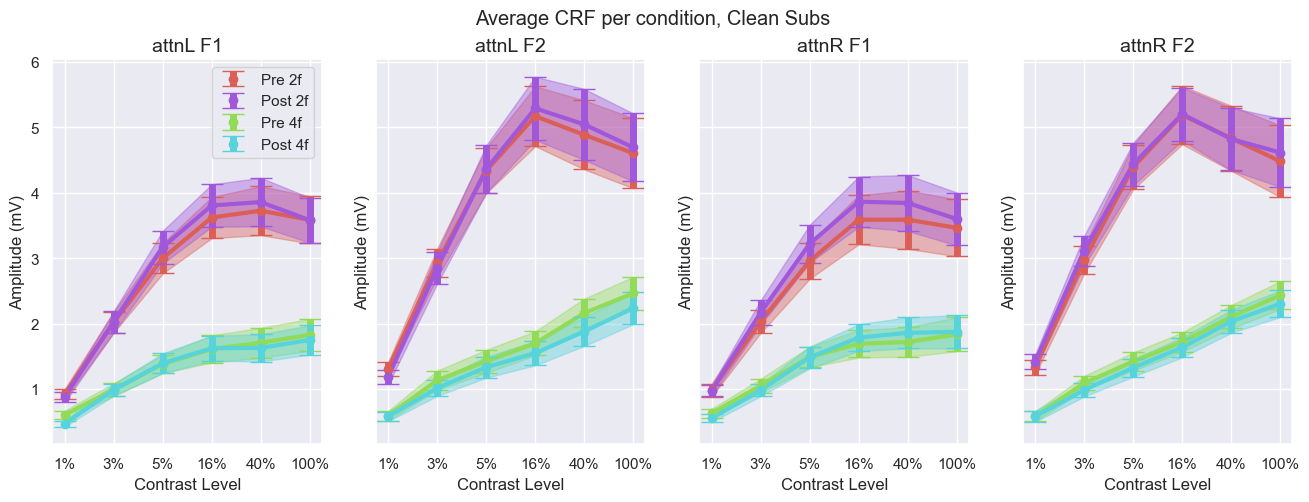

In [14]:
fig,axs = plt.subplots(1,4,figsize = (16,5), sharey = True)

for coIn in range(NumConds):

    aIn = CleanAvgCRF[coIn] # array 12 x 2 
    eIn = avg_err_bars[coIn] # array 12 x 2 
    bckgrnd = CleanIndivCRF[coIn]
    ConditionLabel = data_labels[coIn]

    axs[coIn].plot(x_lev,aIn[0:6,0], color = cp2[0], linewidth = 3 )
    axs[coIn].errorbar(x_lev,aIn[0:6,0],eIn[:6,0],fmt = 'o', label = 'Pre 2f', color = cp2[0], linewidth = 3,elinewidth=5,capsize = 8)
    axs[coIn].fill_between(x_lev, aIn[0:6,0] - eIn[0:6,0], aIn[0:6,0] + eIn[0:6,0], color=cp2[0], alpha=0.4)

    axs[coIn].plot(x_lev,aIn[0:6,1], color = cp2[6], linewidth = 3)
    axs[coIn].errorbar(x_lev,aIn[0:6,1],eIn[:6,1],fmt = 'o', label = 'Post 2f', color = cp2[6], linewidth = 3,elinewidth=5,capsize = 8 )
    axs[coIn].fill_between(x_lev, aIn[0:6,1] - eIn[0:6,1], aIn[0:6,1] + eIn[0:6,1], color=cp2[6], alpha=0.4)

    axs[coIn].plot(x_lev,aIn[6:,0], color = cp2[2], linewidth = 3)
    axs[coIn].errorbar(x_lev,aIn[6:,0],eIn[6:,0],fmt = 'o', label = 'Pre 4f', color = cp2[2], linewidth = 3,elinewidth=5,capsize = 8)
    axs[coIn].fill_between(x_lev, aIn[6:,0] - eIn[6:,0], aIn[6:,0] + eIn[6:,0], color=cp2[2], alpha=0.4)

    axs[coIn].plot(x_lev,aIn[6:,1], color = cp2[4], linewidth = 3 )
    axs[coIn].errorbar(x_lev,aIn[6:,1],eIn[6:,1],fmt = 'o', label = 'Post 4f', color = cp2[4], linewidth = 3,elinewidth=5,capsize = 8)
    axs[coIn].fill_between(x_lev, aIn[6:,1] - eIn[6:,1], aIn[6:,1] + eIn[6:,1], color=cp2[4], alpha=0.4)

    axs[coIn].set_title(f'{ConditionLabel}', fontsize = 14)

    axs[coIn].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[coIn].set_xlabel('Contrast Level')
    axs[coIn].set_ylabel('Amplitude (mV)')

    if coIn == 0:
        axs[0].legend()

plt.suptitle(f'Average CRF per condition, Clean Subs')

#### Get Post - pre Differnces and Perform Final Exclusion Criteria

Starting Response Subtraction ...
Starting STD exclusion for responses < or = :3 std penalties
Now Computing Errorbars...
All Done! :)
Starting Response Subtraction ...
Starting STD exclusion for responses < or = :3 std penalties
Now Computing Errorbars...
All Done! :)
Starting Response Subtraction ...
Starting STD exclusion for responses < or = :3 std penalties
Now Computing Errorbars...
All Done! :)
Starting Response Subtraction ...
Starting STD exclusion for responses < or = :3 std penalties
Now Computing Errorbars...
All Done! :)


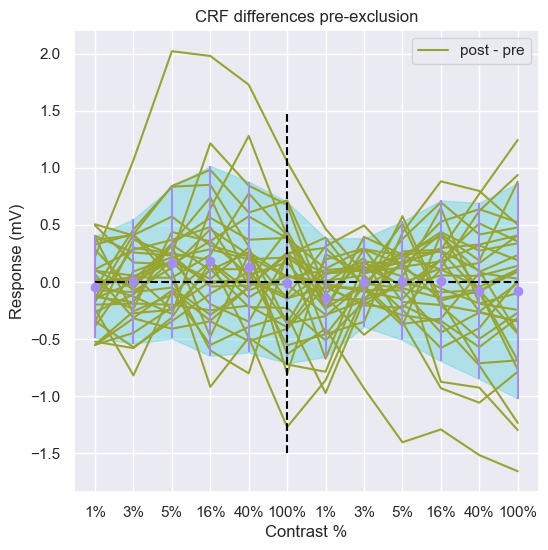

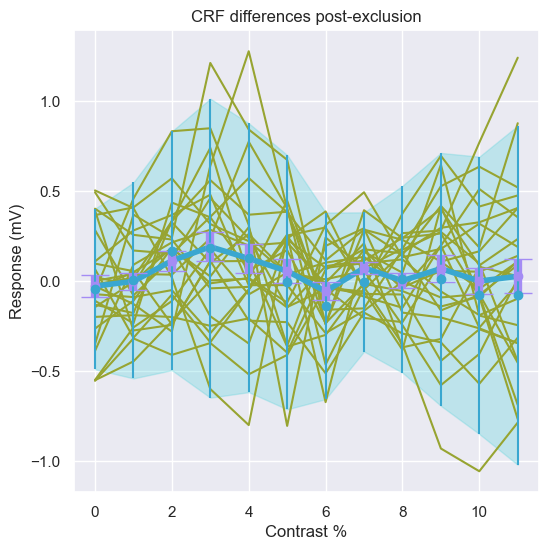

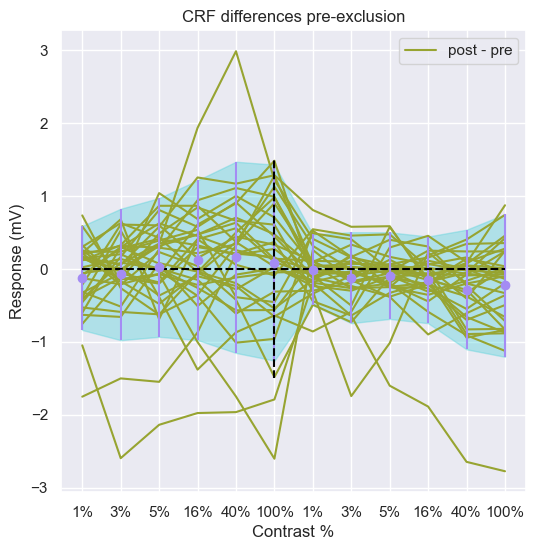

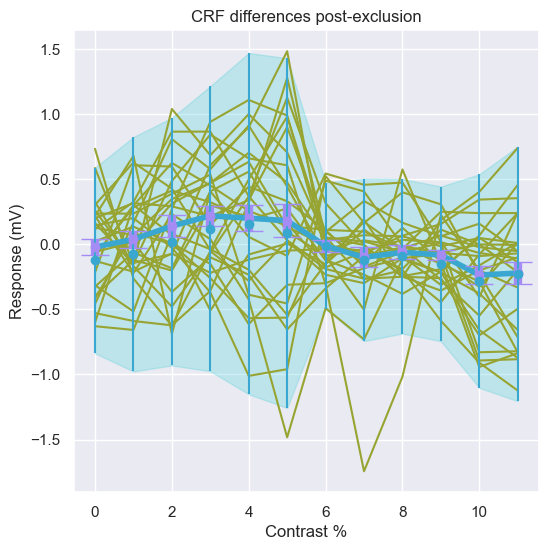

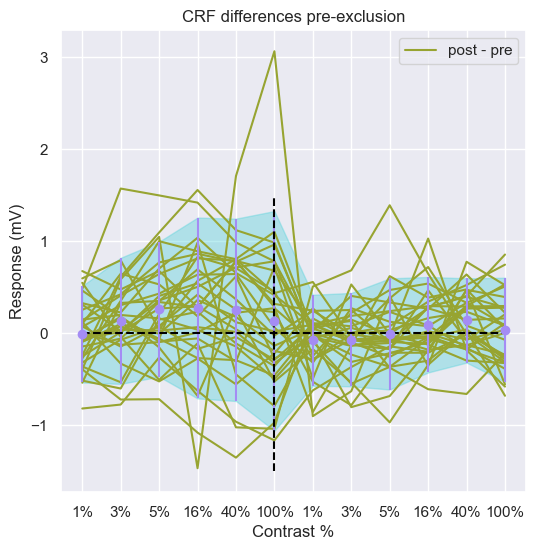

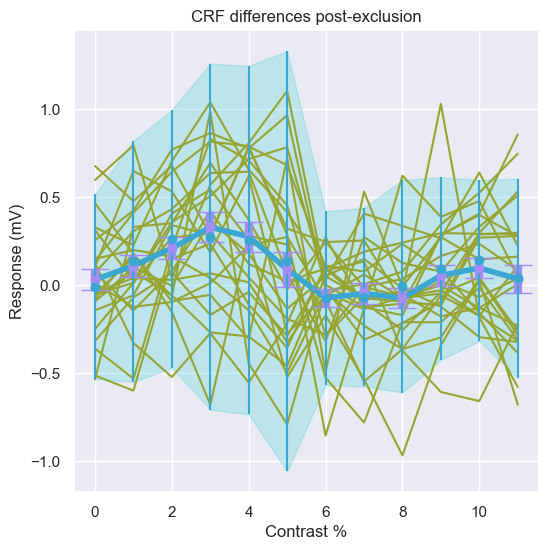

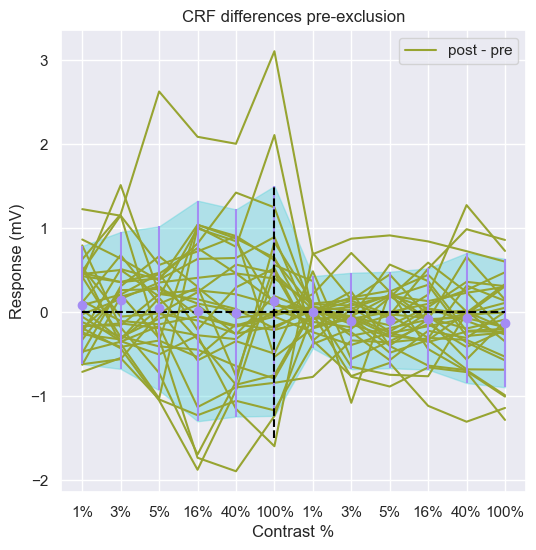

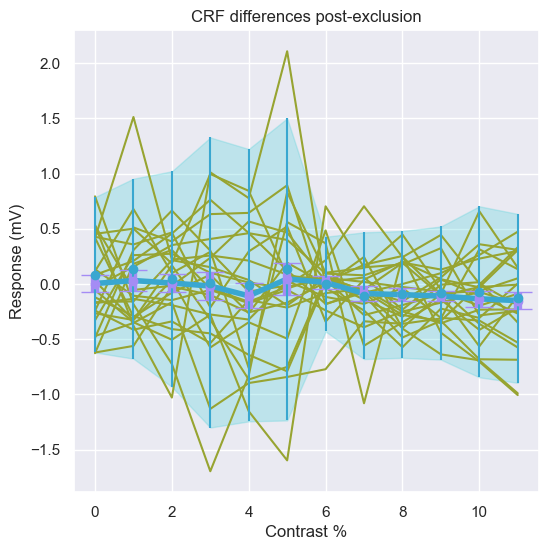

In [15]:
CleanDiffData = {}
CleanPPData = {}
coSubList = {}
AvgCRF = {}
ErrBars = {}
# to get less variable data: can change std thresh OR change penalty threshold
for co in range(NumConds):
    [CleanDiffData[co],CleanPPData[co],AvgCRF[co],ErrBars[co], coSubList[co]] = Clean_DataSet_Information(NumHarms,NumBins,contrast_labs, ppd = CleanIndivCRF[co],coSubList = SubList[co], MaxPen = 3)

In [16]:
note = ['This data contains clean,processed (post-pre) contrast response function differences for each condition, max penalty - 2(3 tech)']

In [18]:
DictOut = {}

DictOut['DiffData'] = CleanDiffData # response differences - 1 row = 1 subj
DictOut['PPData'] = CleanPPData # pre post CRF
DictOut['coSubNames'] = coSubList # subject names

DictOut['Avg'] = AvgCRF # average of data differences 
DictOut['ErrorBars'] = ErrBars # error bars 

DictOut['VoiceMemo'] = note # personal note f what data contains 
DictOut['DictMainKeys'] = data_labels # condition labels per key
DictOut['ContLevs'] = contrast_levels # contrasts used for sweep
DictOut['crfLabs'] = contrast_labs # string of avob for plotting


In [19]:
# set save data dir 
# Set directory to save NR Data in ..new folder
# SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir where files (.pkl, .csv) will be saved
SaveDataDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\CleanCRFDiff\\' # set dir where files (.pkl, .csv) will be saved
FileOutName = 'AllClean_CRF_Diffs_2ndrun' # make sure this file changes each time you save
######################################################
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.pkl' 
MatLabFileN = f'{FileOutName}_{fdnt}.mat'

NewFileNPath = os.path.join(SaveDataDir,FileN)

print('Full New File Dir: ', NewFileNPath)

if not os.path.exists(SaveDataDir):
    os.makedirs(SaveDataDir)
print('Path to Save File is:',SaveDataDir)

Full New File Dir:  C:\plimon\LTP_analysis\RCA_F1\CleanCRFDiff\AllClean_CRF_Diffs_2ndrun_20240314_1337.pkl
Path to Save File is: C:\plimon\LTP_analysis\RCA_F1\CleanCRFDiff\


In [20]:
saveFile = 'n'

if saveFile == 'y':
 
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(DictOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    # save as .mat file or .csv file to import into matlab 
    
    print('Average CRF Differences Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

Average CRF Differences Saved! :))
